
### PPP Calculation of Csh, Total Sandstone Porosity, Sw in Payzone Using Laminated Aquifer Slope Method


Use this workflow having already computed CshAquifer(array),Rw,a,m,n from the picket plot in excel from the aquifer. Prepare arrays for:
- Gamma Ray values every 2ft of pay
- Nuetron and Density values every 2ft of pay
- Rt values every 2 ft of pay (no need to calculate Rss)

use https://apps.automeris.io/wpd/
link to github: https://github.com/AdrianSalinas98/Petroleum-Engineering-Repository



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#- Gamma Shale: 1 value (local max) **NEAR THE PAY ZONE**
#- Gamma Sand: 1 value (local min) **APPROXIMATING AQUIFER**
#- Gamma Aquifer: 1 value (local min)
#- Gamma Pay: Gamma ray of the Pay Zone **[Array]**
#- Csh Aquifer: shale concentration of Aquifer 1 value **MUST BE AT SAME DEPTH AS Gamma Aquifer**

#returns [Array]: CshPay: shale concentration along the payzone

def Csh(GammaShale,GammaAquifer,GammaPay,CshAquifer):
    slope = (1-CshAquifer)/(GammaShale-GammaAquifer) #1 value for each well
    CshPay = slope*(GammaPay-GammaShale)+1 #distribution for each 2ft of pay
    return CshPay

def CshNew(GammaShale,GammaSand,GammaPay):
    CshPay = (GammaPay - GammaSand)/(GammaShale - GammaSand) #distribution for each 2ft of pay
    return CshPay

#-----------------------------------------------------------------------------------------
#NPay: nuetron porosity every 2 ft of pay [Array]
#DPay: density every 2 ft of pay [Array]
#NShale: nuetron porosity of pure shale (1 value)
#DShale: density porosity of pure shale (1 value)
#CshPay: input the CshPay [Array] from above

#returns [Array]: PhiTotal: corrected, total porosity in the pay zone

def TotalPorosity(NPay,DPay,NShale,DShale,CshPay):
    PhiDcorrected = (DPay-(CshPay*DShale))/(1-CshPay)
    PhiNcorrected = (NPay-(CshPay*NShale))/(1-CshPay)
    PhiTotal = ( ((PhiNcorrected**2)+(PhiDcorrected**2))/2 )**.5
    return PhiTotal
#-----------------------------------------------------------------------------------------

#Rw: single value from picket plot
#Rt: DEEP resistivity every 2 ft of pay [Array]
#phiTotal: input array from above
#a,m,n single values from picket plot:

#returns [2-D Array]: of Sw and Shc

def Saturations(Rw,Rt,phiTotal,a,m,n):
    Sw = ((Rw/Rt)*(a/(phiTotal**m)))**(1/n)
    Shc = 1-Sw
    return np.array([Sw,Shc])
#-----------------------------------------------------------------------------------------

#For loops using arrays: GammaPay,Rw,Npay,Dpay,Rt values. Return distribution, weighted 

data = pd.read_csv('template.csv')
GammaPay = np.array(data['GammaPay'])
Rw = np.array(data['Rw'])
Rt = np.array(data['Rt'])
NPay = np.array(data['Npay'])
DPay = np.array(data['Dpay'])


#GammaAquifer is assumed with the I-1 log, so if your pay zone is a Haliburton log, subtract 15 from API reading
GammaShale = 135
GammaAquifer = 60
GammaSand = 45
CshAquifer = 0.1667
NShale = .36 #.402
DShale = .168 #.23
a = 1
m = 2 
n = 2.5


CshPay = np.array([])
CshPayNew = np.array([])
for i in range(len(GammaPay)):
    calc = Csh(GammaShale,GammaAquifer,GammaPay[i],CshAquifer)
    CshPay = np.append(CshPay,calc)
    
    calcNew = CshNew(GammaShale,GammaSand,GammaPay[i])
    CshPayNew = np.append(CshPayNew,calcNew)

PorosityPay = np.array([])
PorosityPayNew = np.array([])
for i in range(len(CshPay)):
    calc1 = TotalPorosity(NPay[i],DPay[i],NShale,DShale,CshPay[i])
    PorosityPay = np.append(PorosityPay,calc1)
    
    calc1New = TotalPorosity(NPay[i],DPay[i],NShale,DShale,CshPayNew[i])
    PorosityPayNew = np.append(PorosityPayNew,calc1New)
    
WaterSaturationPay = np.array([])
WaterSaturationPayNew = np.array([])
OilSaturationPay = np.array([])
for i in range(len(PorosityPay)):
    calc2 = Saturations(Rw[i],Rt[i],PorosityPay[i],a,m,n)
    WaterSaturationPay = np.append(WaterSaturationPay,calc2[0])
    OilSaturationPay = np.append(OilSaturationPay,calc2[1])
    
    calc2New =  Saturations(Rw[i],Rt[i],PorosityPayNew[i],a,m,n)
    WaterSaturationPayNew = np.append(WaterSaturationPayNew,calc2New[0])
    
# print(PorosityPay)
# print(WaterSaturationPay)

#data['PorosityPay'] = PorosityPay
#data['WaterSaturation'] = WaterSaturationPay


data['PorosityPayNew'] = PorosityPayNew
data['WaterSaturationPayNew'] = WaterSaturationPayNew
# print(PorosityPayNew)
# print(WaterSaturationPayNew)

data.to_csv('SandExport.csv')

data




,Depth,GammaPay,Rw,Rt,Npay,Dpay,Sidewall Porosity,Sidewall Saturation,PorosityPayNew,WaterSaturationPayNew
0,8101.233248,112.000000,0.050119,3.0,0.180000,0.180000,0.261,0.604,0.287038,0.528203
1,8117.549045,99.032293,0.050119,1.4,0.302304,0.190511,0.250,0.838,0.220022,0.886291
2,8119.678643,101.871257,0.050119,1.6,0.300000,0.201536,0.228,0.787,0.230157,0.810462
3,8121.520958,100.149701,0.050119,1.7,0.287090,0.197655,0.236,0.746,0.211312,0.846996


## Peicewise funtion for Depth Correlation: Well I-4 (MD to TVD relationship)

[7507. 7610. 7806. 7842. 8124. 8252. 8298. 8352.   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan]
[7335.5758 7422.034  7586.5564 7616.7748 7853.4856 7960.9288 7999.5412
 8044.8688    0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.    ]


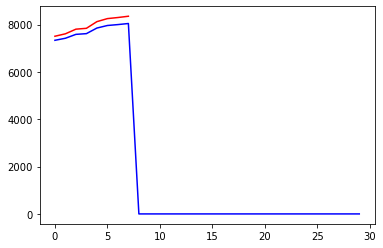

In [3]:
md = pd.read_csv('md.csv')

md.head()
MD = np.array(md['MD'])
TVD = np.array(md['TVD'])
depths = np.array(md['depths'])

newdepths = np.zeros(len(depths))
for i in range(0,len(depths)):
    if depths[i] < 6500.1:
        newdepths[i] = (0.968*depths[i] + 180.991)
    elif depths[i] > 6500.1 and depths[i] < 7275.1:
        newdepths[i] = (0.865*depths[i] + 845.35)
    elif depths[i] > 7275.1:
        newdepths[i] = (0.8394*depths[i] + 1034.2)
        
print(depths)    
print(newdepths)


plt.plot(depths, 'r-',label = 'MD')
plt.plot(newdepths, 'b-', label = 'TVD')

md['depthTVD'] = newdepths
md.to_csv('DepthExport.csv')



### Calculating Average Porosity and Water Saturation for each Sand

- The average distributions across each sand will be weighted based on how much feet of pay each zone has.
- Wells that have thicker payzones will contribute more weight to the average values of Porosity and water saturation.

importing data for distribution visuals, weighted averages already calculated.

/Users/AdrianSalinas/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/AdrianSalinas/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


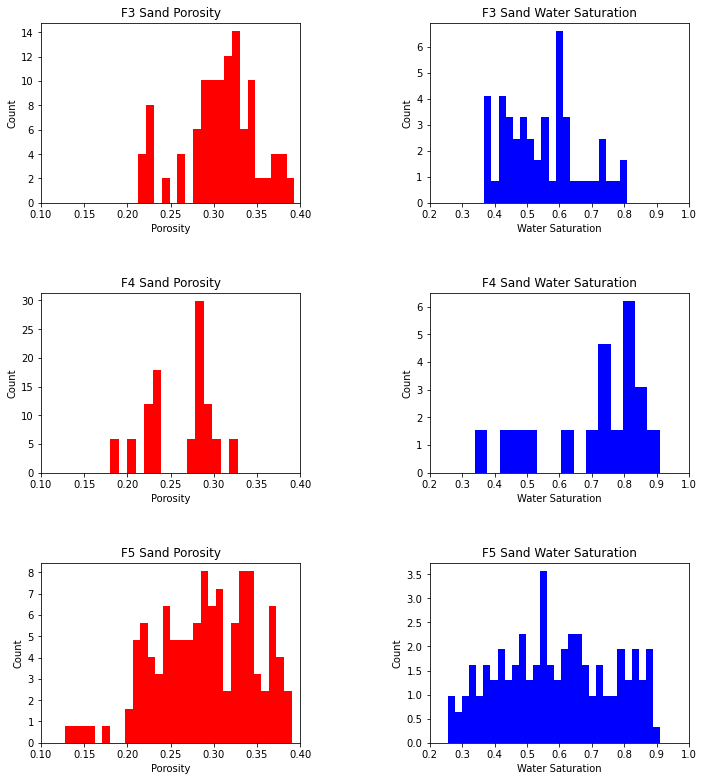

In [4]:
sands = pd.read_csv('sands.csv')

F3Por = sands['F3Por']
F3w =   sands['F3w']
F4Por = sands['F4Por']
F4w = sands['F4w']
F5Por = sands['F5Por']
F5w = sands['F5w']


bins1 = 20
ax1 = plt.subplot(3,2,1)
n, bins,patches = ax1.hist(F3Por,bins1,facecolor = 'r',density=True)
ax1.set_xlim([.1,.4])
ax1.set_xlabel('Porosity' )
ax1.set_ylabel('Count')
ax1.set_title('F3 Sand Porosity')

bins2 = 20
ax2 = plt.subplot(3,2,2)
n, bins,patches = ax2.hist(F3w,bins2,facecolor = 'b',density=True)
ax2.set_xlim([.2,1])
ax2.set_xlabel('Water Saturation')
ax2.set_ylabel('Count')
ax2.set_title('F3 Sand Water Saturation')

bins3 = 15
ax3 = plt.subplot(3,2,3)
n, bins,patches = ax3.hist(F4Por,bins3,facecolor = 'r',density=True)
ax3.set_xlim([.1,.4])
ax3.set_xlabel('Porosity' )
ax3.set_ylabel('Count')
ax3.set_title('F4 Sand Porosity')

bins4 = 15
ax4 = plt.subplot(3,2,4)
n, bins,patches = ax4.hist(F4w,bins4,facecolor = 'b',density=True)
ax4.set_xlim([.2,1])
ax4.set_xlabel('Water Saturation')
ax4.set_ylabel('Count')
ax4.set_title('F4 Sand Water Saturation')

bins5 = 30
ax5 = plt.subplot(3,2,5)
n, bins,patches = ax5.hist(F5Por,bins5,facecolor = 'r',density=True)
ax5.set_xlim([.1,.4])
ax5.set_xlabel('Porosity' )
ax5.set_ylabel('Count')
ax5.set_title('F5 Sand Porosity')

bins6 = 30
ax6 = plt.subplot(3,2,6)
n, bins,patches = ax6.hist(F5w,bins6,facecolor = 'b',density=True)
ax6.set_xlim([.2,1])
ax6.set_xlabel('Water Saturation')
ax6.set_ylabel('Count')
ax6.set_title('F5 Sand Water Saturation')

# bins7 = 15
# ax7 = plt.subplot(4,2,7)
# n, bins,patches = ax7.hist(F5DPor,bins7,facecolor = 'r',density=True)
# ax7.set_xlim([.1,.4])
# ax7.set_xlabel('Porosity' )
# ax7.set_ylabel('Count')
# ax7.set_title('F5D Sand Porosity')

# bins8 = 15
# ax8 = plt.subplot(4,2,8)
# n, bins,patches = ax8.hist(F5Dw,bins8,facecolor = 'b',density=True)
# ax8.set_xlim([.2,1])
# ax8.set_xlabel('Water Saturation')
# ax8.set_ylabel('Count')
# ax8.set_title('F5D Sand Water Saturation')



plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=2.5, wspace=.5, hspace=.5)

In [5]:
summary = sands.describe()

df2 = pd.DataFrame([[0.31,0.53,0.26,0.71,0.29,0.59]], columns=['F3Por','F3w','F4Por','F4w','F5Por','F5w'],
                  index = ['Weighted Mean Porosity'])
summaryR = pd.concat([df2, summary]).round(2)
summaryR



# df3 = pd.DataFrame([[]],columns=['F3Por','F3w','F4Por','F4w','F5BPor','F5Bw','F5DPor','F5Dw'],
#                   index = ['Net to Gross Ratio'])


,F3Por,F3w,F4Por,F4w,F5Por,F5w
Weighted Mean Porosity,0.31,0.53,0.26,0.71,0.29,0.59
count,55.00,55.00,17.00,17.00,142.00,142.00
mean,0.31,0.55,0.26,0.71,0.29,0.59
std,0.04,0.12,0.04,0.17,0.06,0.17
min,0.21,0.37,0.18,0.34,0.13,0.26
25%,0.29,0.44,0.23,0.61,0.25,0.46
50%,0.31,0.55,0.28,0.75,0.29,0.57
75%,0.33,0.62,0.29,0.82,0.33,0.72
max,0.39,0.81,0.33,0.91,0.39,0.91


## Contour Map

Lets start by reading in the digitized data from our plats

8178.0
[-329.6119086 1975.176578 ]
[[-2.77203615e+03  1.67350194e+01]
 [-1.62838916e+03 -3.28776487e+01]
 [-4.00850611e+02 -3.22852586e+01]
 [ 4.31153642e+02 -1.48097517e+00]
 [ 1.45826688e+03 -1.70312144e+01]
 [ 2.33322701e+03 -2.72499430e+01]
 [ 3.12961191e+03 -2.51765778e+01]
 [ 3.73822435e+03 -4.65026202e+01]
 [ 3.88272196e+03  1.88616997e+03]
 [ 3.97171717e+03  3.24437229e+03]
 [ 4.11493886e+03  4.85004557e+03]
 [ 2.68229665e+03  4.93431305e+03]
 [ 1.32291334e+03  4.94379130e+03]
 [-1.38224349e+01  4.90750740e+03]
 [-8.93779904e+02  4.93697881e+03]
 [-1.75938331e+03  2.79519253e+03]
 [-2.37671451e+03  1.23202324e+03]
 [-2.75108985e+03  1.84973798e+02]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]]


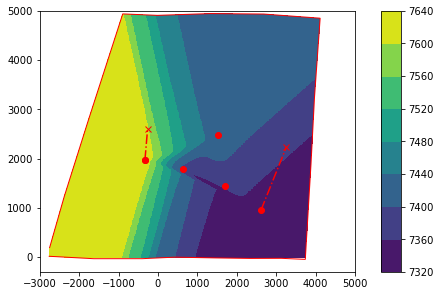

In [6]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.interpolate import griddata

plat = pd.read_csv('Plat.csv')
points = np.array(plat.iloc[0:23,[2,3]].copy()) # x,y
values = np.array(plat.iloc[0:23,4].copy())     # z
boundary_points = np.array(plat.iloc[:,[0,1]].copy())

print(values[-1])
print(points[-1])
#min and max of x and y points chosen for the boundary, @ z resolution
Nx = 500
Ny = 500
xi = np.linspace(-3000, 5000,Nx)
yi = np.linspace(0, 5000,Ny)
X,Y = np.meshgrid(xi,yi)

Z = griddata(points,values,(X,Y),method = 'cubic') 
boolean = ~np.isnan(Z) #does opposite of replacing nan with true(nan are false)
#choose values based on true index(real values)
#doing the same as spreadsheetbut with real values (make x_column beside y_column and corresponsding Z_column)
Z1 = Z[boolean]
Z1 = Z1.reshape(-1)
X1 = X[boolean]
X1 = X1.reshape(-1)
Y1 = Y[boolean]
Y1 = Y1.reshape(-1)

points2 = np.column_stack((X1,Y1)) 
Z2 = griddata(points2,Z1,(X,Y),method = 'nearest') 

#remove negative depth values
Z2 = np.where(Z2<0,0.0,Z2)

#set boundary as a path object
path = Path(boundary_points)

#flatten our figure space(X,Y meshgrid), then arange in (N by 2 array for 'contains_points' function)
XX,YY = X.flatten(), Y.flatten()
XY = np.vstack((XX,YY)).T

path_boolean = path.contains_points(XY)
path_boolean = path_boolean.reshape(Ny,Nx)

#make points 'outside' path nan 
outside = path_boolean == False
Z2[outside] = np.nan

fig,ax = plt.subplots(constrained_layout = True)
C = ax.contourf(X,Y,Z2)
cbar = fig.colorbar(C)

#visualize reservoir boundary
patch = PathPatch(path,facecolor = 'none',edgecolor='r')
ax.add_patch(patch)

#show wells
ax.plot(1531.419458,2480.929597,'ro',label = 'I1')
ax.plot(1702.392344,1448.838004,'ro',label = 'I2')
ax.plot(635.9383307,1781.909319,'ro',label = 'I3')

ax.plot(2616.05529,957.5985418,'ro',label = 'I4_SH')
ax.plot(3255.077087,2229.756209,'rx',label = 'I4_BHL')
I4sh = [2616.05529,3255.077087]
I4bh = [957.5985418,2229.756209]
ax.plot(I4sh,I4bh,'r-.')


ax.plot(-329.6119086,1975.176578,'ro',label = 'N1')
ax.plot(-329.6119086,1975.176578,'ro',label = 'NST_SH')
ax.plot(-263.7958533,2592.891319,'rx',label = 'NST_BHL')
N1STsh = [-329.6119086,-263.7958533]
N1STbh = [1975.176578,2592.891319]
ax.plot(N1STsh,N1STbh,'r-.')

ax.legend = True


print(boundary_points)

## THICKNESS

In [69]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.interpolate import griddata

plat = pd.read_csv('Thicc.csv')
points = np.array(plat.iloc[0:23,[2,3]].copy()) # x,y
values = np.array(plat.iloc[0:23,4].copy())     # z
boundary_points = np.array(plat.iloc[:,[0,1]].copy())

print(values[-1])
print(points[-1])
#min and max of x and y points chosen for the boundary, @ z resolution
Nx = 500
Ny = 500
xi = np.linspace(-3000, 5000,Nx)
yi = np.linspace(0, 5000,Ny)
X,Y = np.meshgrid(xi,yi)

Z = griddata(points,values,(X,Y),method = 'cubic') 
boolean = ~np.isnan(Z) #does opposite of replacing nan with true(nan are false)
#choose values based on true index(real values)
#doing the same as spreadsheetbut with real values (make x_column beside y_column and corresponsding Z_column)
Z1 = Z[boolean]
Z1 = Z1.reshape(-1)
X1 = X[boolean]
X1 = X1.reshape(-1)
Y1 = Y[boolean]
Y1 = Y1.reshape(-1)

points2 = np.column_stack((X1,Y1)) 
Z2 = griddata(points2,Z1,(X,Y),method = 'nearest') 

#remove negative depth values
Z2 = np.where(Z2<0,0.0,Z2)

#set boundary as a path object
path = Path(boundary_points)

#flatten our figure space(X,Y meshgrid), then arange in (N by 2 array for 'contains_points' function)
XX,YY = X.flatten(), Y.flatten()
XY = np.vstack((XX,YY)).T

path_boolean = path.contains_points(XY)
path_boolean = path_boolean.reshape(Ny,Nx)

#make points 'outside' path nan 
outside = path_boolean == False
Z2[outside] = np.nan

fig,ax = plt.subplots(constrained_layout = True)
C = ax.contourf(X,Y,Z2)
cbar = fig.colorbar(C)

#visualize reservoir boundary
patch = PathPatch(path,facecolor = 'none',edgecolor='r')
ax.add_patch(patch)

#show wells
ax.plot(1531.419458,2480.929597,'ro',label = 'I1')
ax.plot(1702.392344,1448.838004,'ro',label = 'I2')
ax.plot(635.9383307,1781.909319,'ro',label = 'I3')

ax.plot(2616.05529,957.5985418,'ro',label = 'I4_SH')
ax.plot(3255.077087,2229.756209,'rx',label = 'I4_BHL')
I4sh = [2616.05529,3255.077087]
I4bh = [957.5985418,2229.756209]
ax.plot(I4sh,I4bh,'r-.')


ax.plot(-329.6119086,1975.176578,'ro',label = 'N1')
ax.plot(-329.6119086,1975.176578,'ro',label = 'NST_SH')
ax.plot(-263.7958533,2592.891319,'rx',label = 'NST_BHL')
N1STsh = [-329.6119086,-263.7958533]
N1STbh = [1975.176578,2592.891319]
ax.plot(N1STsh,N1STbh,'r-.')

ax.legend = True


print(boundary_points)

FileNotFoundError: [Errno 2] File Thicc.csv does not exist: 'Thicc.csv'